### **Teste Com voz Real**

In [ ]:
!pip install ffmpeg-python

In [ ]:
from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import io
import ffmpeg

# --- Variável global para armazenar o áudio ---
# Vamos guardar o áudio em formato de bytes na memória
audio_data_bytes = None
# ---------------------------------------------


# --- Funções Python que serão chamadas pelo JavaScript ---
from google.colab import output

def save_audio(b64data):
  """
  Callback do JS: Recebe o áudio em base64 e salva na variável global.
  """
  global audio_data_bytes
  # Decodifica o base64 para bytes
  audio_data_bytes = b64decode(b64data)
  print("Áudio recebido! Pronto para processar na Célula 3.")

# Registra a função 'save_audio' para que o JS possa chamá-la
output.register_callback('notebook.save_audio', save_audio)
# --------------------------------------------------------


# --- O Código JavaScript para Gravação ---
# Este código é executado no SEU NAVEGADOR, não no servidor Colab.
RECORD_JS = """
<script>
var stream;         // Stream do microfone
var recorder;       // Objeto MediaRecorder
var chunks;         // Pedaços do áudio gravado
var audio;          // (Não usado aqui, mas útil para debug)

async function startRecording() {
  // 1. Pedir permissão e obter o stream do microfone
  stream = await navigator.mediaDevices.getUserMedia({audio: true});
  recorder = new MediaRecorder(stream);
  chunks = [];

  // 2. O que fazer quando o áudio estiver disponível
  recorder.ondataavailable = e => chunks.push(e.data);

  // 3. O que fazer quando a gravação parar (botão 'Parar' clicado)
  recorder.onstop = e => {
    // Combina todos os pedaços em um único Blob
    const blob = new Blob(chunks, { 'type' : 'audio/webm' }); // Formato padrão do navegador
    const reader = new FileReader();

    reader.onload = () => {
      // Converte o Blob para base64
      const b64data = reader.result.split(',')[1];

      // Envia os dados em base64 para o Python (chamando a função 'save_audio')
      google.colab.kernel.invokeFunction('notebook.save_audio', [b64data], {});
    };
    reader.readAsDataURL(blob);
  };

  // 4. Inicia a gravação
  recorder.start();

  // Atualiza os botões
  document.getElementById('start').disabled = true;
  document.getElementById('stop').disabled = false;
}

function stopRecording() {
  // Para o gravador
  recorder.stop();
  // Para o stream do microfone (desliga a luzinha)
  stream.getTracks().forEach(track => track.stop());

  // Atualiza os botões
  document.getElementById('start').disabled = false;
  document.getElementById('stop').disabled = true;
}

// --- Criação dos Botões (HTML) ---
document.body.appendChild(document.createTextNode('Clique para gravar: '));
var startButton = document.createElement('button');
startButton.id = 'start';
startButton.innerHTML = '▶️ Gravar';
startButton.onclick = startRecording;
document.body.appendChild(startButton);

var stopButton = document.createElement('button');
stopButton.id = 'stop';
stopButton.innerHTML = '⏹️ Parar';
stopButton.disabled = true;
stopButton.onclick = stopRecording;
document.body.appendChild(stopButton);
</script>
"""

# Exibe o HTML/JS na saída da célula
display(HTML(RECORD_JS))


ModuleNotFoundError: No module named 'ffmpeg'

In [ ]:
from IPython.display import Audio

if audio_data_bytes:
  print("Processando e salvando o áudio...")

  AUDIO_PATH = "/content/audio_teste.wav"
  TARGET_SR = 16000

  # O áudio gravado está em 'audio_data_bytes' no formato webm/opus
  # Precisamos usar o ffmpeg para converter

  try:
    # Usa o ffmpeg para ler os bytes da memória (stdin)
    # e converter para o formato/taxa de amostragem desejados
    process = (
        ffmpeg
        .input('pipe:') # Lê da entrada padrão (stdin)
        .output(AUDIO_PATH, acodec='pcm_s16le', ar=TARGET_SR, ac=1) # pcm_s16le é o formato WAV
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, overwrite_output=True)
    )

    # Envia os dados do áudio para o processo ffmpeg
    out, err = process.communicate(input=audio_data_bytes)

    if process.returncode != 0:
      print("Erro no FFMPEG:")
      print(err.decode())
    else:
      print(f"Áudio salvo com sucesso em: {AUDIO_PATH}")
      print(f"Taxa de amostragem: {TARGET_SR} Hz")

      # Toca o áudio salvo para verificação
      display(Audio(AUDIO_PATH))

  except ffmpeg.Error as e:
    print('Erro no ffmpeg:')
    print(e.stderr.decode())
  except Exception as e:
    print(f"Ocorreu um erro: {e}")

else:
  print("Nenhum áudio foi gravado ainda. Rode a Célula 2, grave e pare a gravação primeiro.")

# Limpa a variável para a próxima gravação
audio_data_bytes = None

NameError: name 'audio_data_bytes' is not defined

In [ ]:
import shutil
import os
from google.colab import drive
drive.mount('/content/drive')


MODEL_DIR = "/content/drive/MyDrive/release_in_the_wild/teste"

# caminho de origem (onde está o arquivo no Drive)
origem = os.path.join(MODEL_DIR, "tente-adivinhar-se-sou-verdadeiro-1763606573591.wav")

# caminho de destino em /content
AUDIO_PATH = "/content/audio_teste.wav"

# copia o arquivo
shutil.copy(origem, AUDIO_PATH)

print("Arquivo copiado para:", AUDIO_PATH)
display(Audio(AUDIO_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivo copiado para: /content/audio_teste.wav


In [ ]:
import os
import joblib
from google.colab import drive
drive.mount('/content/drive')

MODEL_DIR = "/content/drive/MyDrive/modelos_deepfake"
SVM_SAVE = os.path.join(MODEL_DIR, "svm_mfcc.pkl")

svm = joblib.load(SVM_SAVE)
print("Modelo SVM carregado de:", SVM_SAVE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo SVM carregado de: /content/drive/MyDrive/modelos_deepfake/svm_mfcc.pkl


In [ ]:
import soundfile as sf
import librosa
import numpy as np

SR = 16000      # mesmo que no treino
N_MFCC = 40     # mesmo que no treino

def load_audio(path, sr=SR):
    wav, fs = sf.read(path)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if fs != sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=fs, target_sr=sr)
    return wav.astype(np.float32)

def extract_mfcc_mean(wave, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)  # shape: (n_mfcc,)

def predict_audio_real_fake(audio_path, model):
    # 1) Carregar onda
    wav = load_audio(audio_path)

    # 2) Extrair MFCC médio (mesmo do treino)
    feat = extract_mfcc_mean(wav)       # shape: (N_MFCC,)

    # 3) Transformar em formato (1, n_features) pro SVM
    X = feat.reshape(1, -1)

    # 4) Prever
    pred = model.predict(X)[0]

    # 5) Probabilidades (se treinou com probability=True)
    try:
        proba = model.predict_proba(X)[0]
    except:
        proba = None

    return pred, proba



In [ ]:
pred, proba = predict_audio_real_fake(AUDIO_PATH, svm)

# Ajuste esse mapeamento conforme seus labels reais!
label_map = {
    0: "REAL",
    1: "FAKE"
}

print("Classe numérica prevista:", pred)
print("Resultado:", label_map.get(pred, f"Desconhecido ({pred})"))

if proba is not None:
    print("Probabilidades por classe (na ordem svm.classes_):", svm.classes_, proba)
    idx = list(svm.classes_).index(pred)
    print(f"Confiança na classe {label_map.get(pred, pred)}: {proba[idx]*100:.2f}%")


Classe numérica prevista: 0
Resultado: REAL
Probabilidades por classe (na ordem svm.classes_): [0 1] [0.99719951 0.00280049]
Confiança na classe REAL: 99.72%


## **Treinamento**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

In [3]:
import os
path = '/content/drive/MyDrive/release_in_the_wild'
os.chdir(path)
print("Diretório atual:", os.getcwd())

Diretório atual: /content/drive/MyDrive/release_in_the_wild


Listing files...
Found 19999 real files and 17215 fake files.
Extracting MFCC features (may take a while)...


100%|██████████| 37214/37214 [3:09:21<00:00,  3.28it/s]


MFCC matrix shape: (37214, 40)
Training SVM baseline on MFCC means...
Saved SVM to /content/drive/MyDrive/modelos_deepfake/svm_mfcc.pkl

📊 SVM MFCC Evaluation Report
Accuracy: 0.9793
AUC: 0.9970

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      4000
        Fake       0.98      0.98      0.98      3443

    accuracy                           0.98      7443
   macro avg       0.98      0.98      0.98      7443
weighted avg       0.98      0.98      0.98      7443



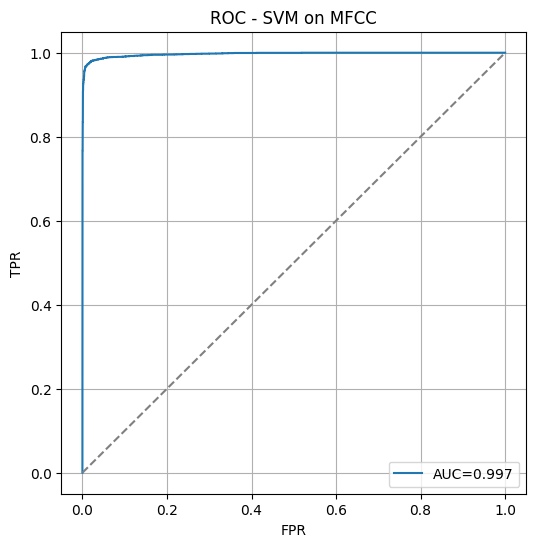

In [4]:
import os
import glob
import random
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# ---------- Configuration ----------
DATA_DIR = '/content/drive/MyDrive/release_in_the_wild'
SR = 16000                         # sampling rate
N_MFCC = 40
RANDOM_SEED = 42
MODEL_DIR = "/content/drive/MyDrive/modelos_deepfake"
os.makedirs(MODEL_DIR, exist_ok=True)
SVM_SAVE = os.path.join(MODEL_DIR, "svm_mfcc.pkl")
# -----------------------------------

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------- Utilities ----------
def list_audio_files(base_dir, exts=('.wav', '.flac', '.mp3')):
    """
    Lista todos os arquivos de áudio dentro das pastas 'real' e 'fake',
    percorrendo recursivamente todas as subpastas.

    Retorna:
        real_files, fake_files  ->  duas listas com caminhos completos
    """
    p_real = os.path.join(base_dir, "real")
    p_fake = os.path.join(base_dir, "fake")

    real_files = []
    fake_files = []

    # Percorre todas as subpastas de REAL
    if os.path.isdir(p_real):
        for root, _, files in os.walk(p_real):
            for f in files:
                if f.lower().endswith(exts):
                    file_path = os.path.join(root, f)
                    real_files.append(file_path)

    # Percorre todas as subpastas de FAKE
    if os.path.isdir(p_fake):
        for root, _, files in os.walk(p_fake):
            for f in files:
                if f.lower().endswith(exts):
                    file_path = os.path.join(root, f)
                    fake_files.append(file_path)

    return real_files, fake_files


def load_audio(path, sr=SR):
    wav, fs = sf.read(path)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if fs != sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=fs, target_sr=sr)
    return wav.astype(np.float32)

def extract_mfcc_mean(wave, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)  # shape: (n_mfcc,)

# ---------- Build dataset ----------
print("Listing files...")
real_files, fake_files = list_audio_files(DATA_DIR)
print(f"Found {len(real_files)} real files and {len(fake_files)} fake files.")

files = [(p, 0) for p in real_files] + [(p, 1) for p in fake_files]
random.shuffle(files)

mfcc_X, labels = [], []
print("Extracting MFCC features (may take a while)...")
for path, lbl in tqdm(files):
    try:
        wav = load_audio(path)
        mf = extract_mfcc_mean(wav)
        mfcc_X.append(mf)
        labels.append(lbl)
    except Exception as e:
        print("Failed on", path, e)

mfcc_X = np.vstack(mfcc_X)
labels = np.array(labels)
print("MFCC matrix shape:", mfcc_X.shape)

# ---------- Train & Save SVM ----------
print("Training SVM baseline on MFCC means...")
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_X, labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED
)
svm = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_SEED)
svm.fit(X_train, y_train)

# Save model
joblib.dump(svm, SVM_SAVE)
print("Saved SVM to", SVM_SAVE)

# ---------- Load model & Evaluate ----------
svm = joblib.load(SVM_SAVE)
y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print("\n📊 SVM MFCC Evaluation Report")
print("================================")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# ---------- Plot ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - SVM on MFCC")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import random
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

# ================================
# 1. Monta o Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')

# ================================
# 2. Configurações
# ================================
DATA_DIR = '/content/drive/MyDrive/release_in_the_wild'
SR = 16000
N_MFCC = 40
RANDOM_SEED = 42

MODEL_PATH = "/content/drive/MyDrive/modelos_deepfake/svm_mfcc.pkl"

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ================================
# 3. Funções auxiliares
# ================================
def list_audio_files(base_dir, exts=('.wav', '.flac', '.mp3')):
    real_dir = os.path.join(base_dir, "real")
    fake_dir = os.path.join(base_dir, "fake")

    real_files = []
    fake_files = []

    for root, _, files in os.walk(real_dir):
        for f in files:
            if f.lower().endswith(exts):
                real_files.append(os.path.join(root, f))

    for root, _, files in os.walk(fake_dir):
        for f in files:
            if f.lower().endswith(exts):
                fake_files.append(os.path.join(root, f))

    return real_files, fake_files


def load_audio(path, sr=SR):
    wav, fs = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if fs != sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=fs, target_sr=sr)
    return wav.astype(np.float32)


def extract_mfcc_mean(wave, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)


# ================================
# 4. RECONSTRUIR O DATASET (SEM TREINO)
# ================================
print("Carregando áudios...")
real_files, fake_files = list_audio_files(DATA_DIR)
print(f"Real: {len(real_files)}, Fake: {len(fake_files)}")

files = [(p, 0) for p in real_files] + [(p, 1) for p in fake_files]
random.shuffle(files)

X, y = [], []
print("Extraindo MFCC mean...")
for path, lbl in tqdm(files):
    try:
        wav = load_audio(path)
        mfcc = extract_mfcc_mean(wav)
        X.append(mfcc)
        y.append(lbl)
    except Exception as e:
        print("Erro no arquivo:", path, e)

X = np.vstack(X)
y = np.array(y)

print("Dataset:", X.shape, y.shape)

# mesma divisão usada no treinamento original
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print("Test shape:", X_test.shape)

# ================================
# 5. CARREGAR O MODELO SVM
# ================================
svm = joblib.load(MODEL_PATH)
print("Modelo SVM carregado!")

# ================================
# 6. AVALIAÇÃO
# ================================
print("\n▶ Fazendo previsões...")
y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print("\n📊 RESULTADOS DA AVALIAÇÃO SVM")
print("====================================")
print(f"Accuracy : {acc:.4f}")
print(f"AUC      : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# ================================
# 7. Matrix de Confusão
# ================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"],
            yticklabels=["Real","Fake"])
plt.title("Confusion Matrix - SVM MFCC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ================================
# 8. Curva ROC
# ================================
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM MFCC")
plt.legend()
plt.grid(True)
plt.show()


Mounted at /content/drive
Carregando áudios...
Real: 19999, Fake: 17215
Extraindo MFCC mean...


  3%|▎         | 1149/37214 [06:23<3:20:22,  3.00it/s]


KeyboardInterrupt: 